In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

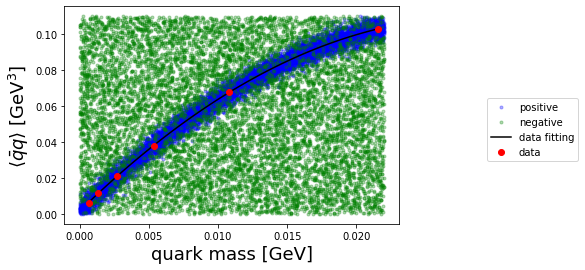

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [14]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [6]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

In [17]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.003*eta(i, eta_ini, eta_fin, N_layer)**4)
print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
[ 6.470729   9.184615  -2.1117423  2.0842507  6.7156415  2.4966247
  5.619274   8.195452  -1.0166072 -4.411922   7.900365   3.112837
  6.56512    1.1609976  5.2822022]


# 3. Train your NN

In [18]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

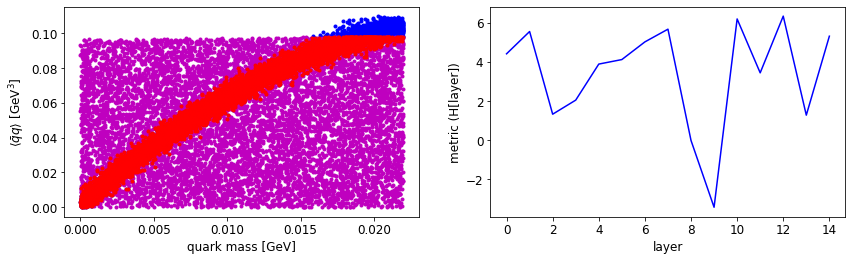

training epoch: 0,   loss: 0.33018848299980164
lambda: -0.40145018696784973,   AdS radius: 0.8599539995193481[1/GeV]
[ 4.4077992   5.546199    1.3260708   2.0442302   3.8837466   4.1138625
  5.016299    5.6652985  -0.01485686 -3.4231288   6.187446    3.4369566
  6.331866    1.2772418   5.3072014 ]


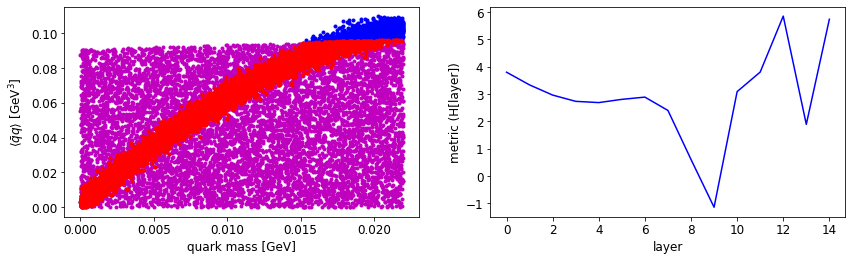

training epoch: 100,   loss: 0.2504279911518097
lambda: -3.2599403858184814,   AdS radius: 1.0639138221740723[1/GeV]
[ 3.8011112  3.3348367  2.9634333  2.7344484  2.6889257  2.807119
  2.8892064  2.4014227  0.607537  -1.1413983  3.0902886  3.8053598
  5.853707   1.8929836  5.7390985]


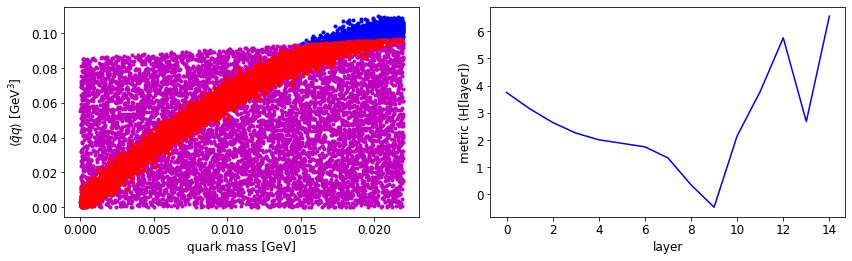

training epoch: 200,   loss: 0.24210025370121002
lambda: -5.909101486206055,   AdS radius: 1.3479284048080444[1/GeV]
[ 3.7469616   3.149666    2.6412935   2.252487    2.0035892   1.8738148
  1.7436662   1.334937    0.34485275 -0.48278183  2.1481013   3.780974
  5.762357    2.674574    6.5614486 ]


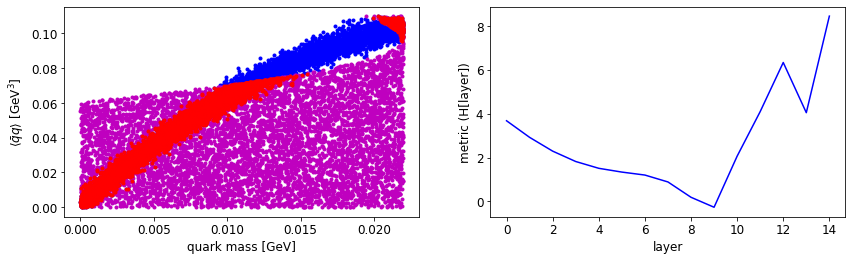

training epoch: 300,   loss: 0.22488778829574585
lambda: -6.682009220123291,   AdS radius: 1.7665690183639526[1/GeV]
[ 3.6757486   2.9186382   2.2902453   1.8168079   1.5069981   1.3348496
  1.1992991   0.8845954   0.18547535 -0.26896173  2.060574    4.094036
  6.3334675   4.044447    8.449033  ]


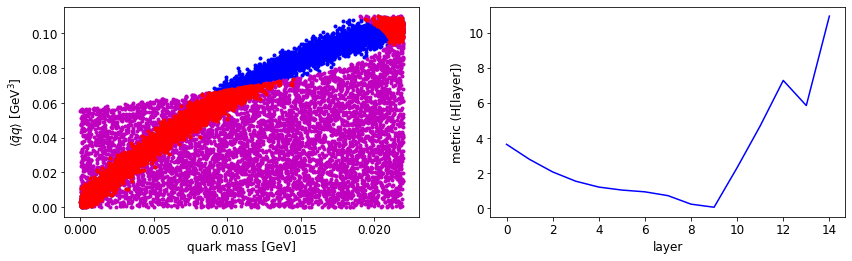

training epoch: 400,   loss: 0.2153412103652954
lambda: -6.239301681518555,   AdS radius: 1.7728533744812012[1/GeV]
[ 3.6343615   2.7722898   2.058882    1.5295696   1.1948773   1.0249158
  0.92356485  0.70606583  0.22062929  0.04425186  2.304194    4.683422
  7.278671    5.8455033  10.947972  ]


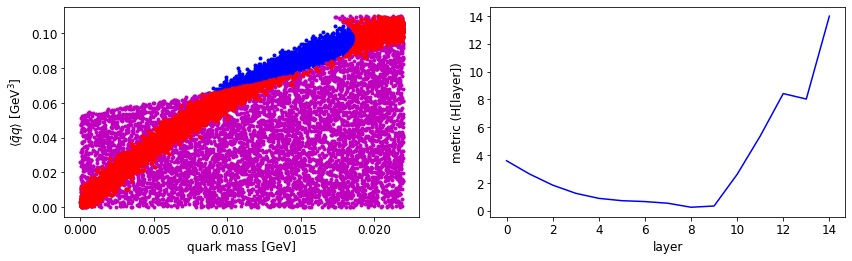

training epoch: 500,   loss: 0.20263269543647766
lambda: -5.608373165130615,   AdS radius: 1.7679606676101685[1/GeV]
[ 3.5964577   2.6404686   1.8450121   1.2570161   0.8937406   0.72640747
  0.6630511   0.54210347  0.2549414   0.34368715  2.6179197   5.3663397
  8.423176    8.029141   13.988795  ]


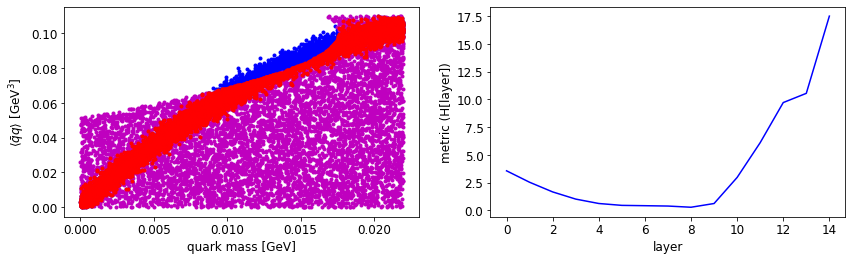

training epoch: 600,   loss: 0.18978093564510345
lambda: -4.745022773742676,   AdS radius: 1.7554320096969604[1/GeV]
[ 3.5709558   2.540022    1.6706853   1.0239038   0.6277159   0.45846963
  0.42939812  0.39762467  0.2900101   0.6258213   2.9734461   6.106344
  9.716967   10.548232   17.502203  ]


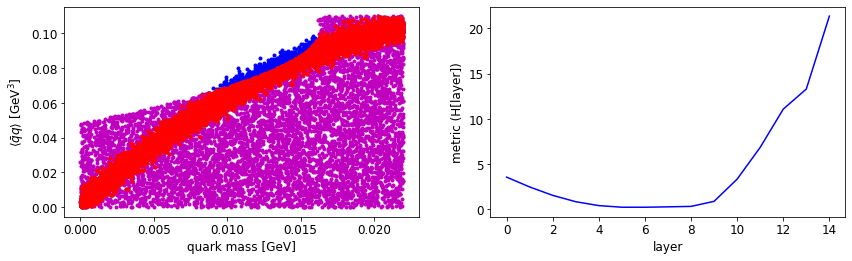

training epoch: 700,   loss: 0.17746306955814362
lambda: -3.6466617584228516,   AdS radius: 1.7674075365066528[1/GeV]
[ 3.5553792   2.4706993   1.5393128   0.836382    0.4035754   0.22584714
  0.22307897  0.26825377  0.31763592  0.8757766   3.3311455   6.84692
 11.07677    13.3022     21.36888   ]


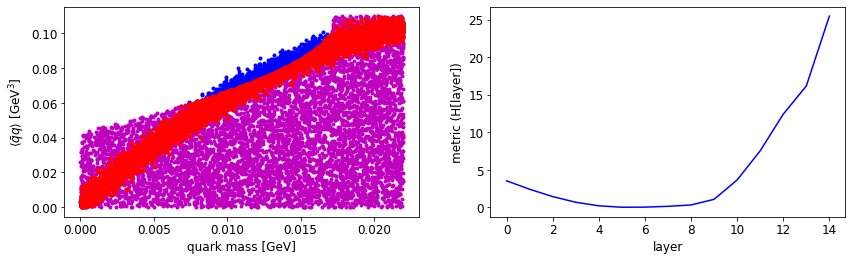

training epoch: 800,   loss: 0.166303813457489
lambda: -2.2918381690979004,   AdS radius: 1.8130779266357422[1/GeV]
[ 3.550907    2.4296303   1.4486544   0.69489264  0.224136    0.03212646
  0.04664012  0.15439384  0.33578292  1.0859507   3.66231     7.540193
 12.420668   16.171677   25.472326  ]


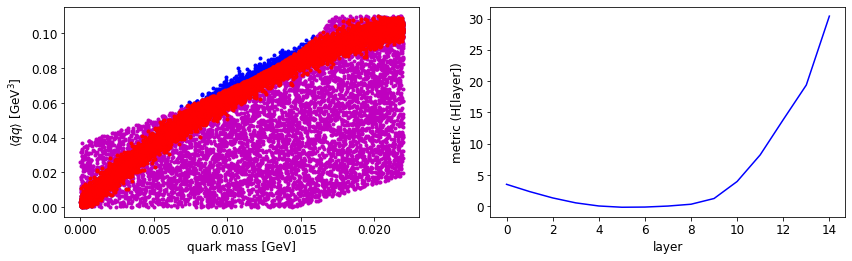

training epoch: 900,   loss: 0.14581342041492462
lambda: -0.3647012412548065,   AdS radius: 2.1569244861602783[1/GeV]
[ 3.5018888e+00  2.3422184e+00  1.3281391e+00  5.3892583e-01
  4.0000323e-02 -1.6251497e-01 -1.3269177e-01  2.7847353e-02
  3.1898358e-01  1.2344339e+00  3.9560111e+00  8.2072573e+00
  1.3838782e+01  1.9373861e+01  3.0389673e+01]


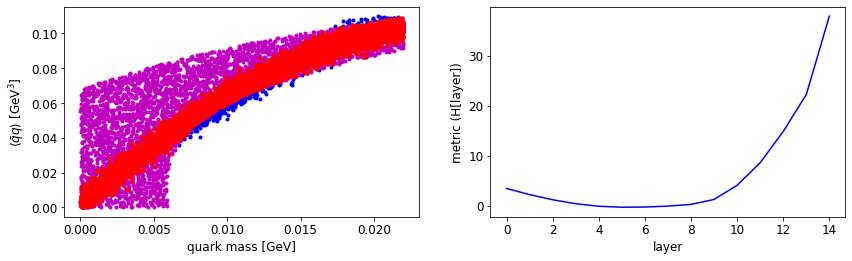

training epoch: 1000,   loss: 0.059915561228990555
lambda: 0.007288488559424877,   AdS radius: 3.943220615386963[1/GeV]
[ 3.4473357   2.2260358   1.198898    0.40354452 -0.0985032  -0.29828554
 -0.2566818  -0.0706259   0.26806685  1.2605128   4.0887117   8.594632
 14.845719   22.210966   37.8703    ]


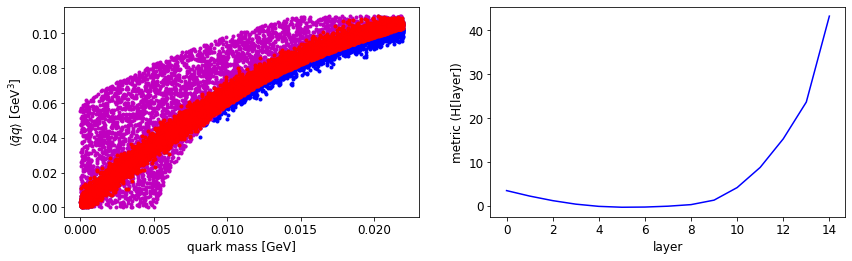

training epoch: 1100,   loss: 0.05387419834733009
lambda: 0.003130850614979863,   AdS radius: 4.015778064727783[1/GeV]
[ 3.4729984   2.2289524   1.1889685   0.38770583 -0.11842932 -0.31966722
 -0.27541676 -0.08051832  0.27675763  1.2989612   4.161123    8.758156
 15.260747   23.64242    43.222435  ]


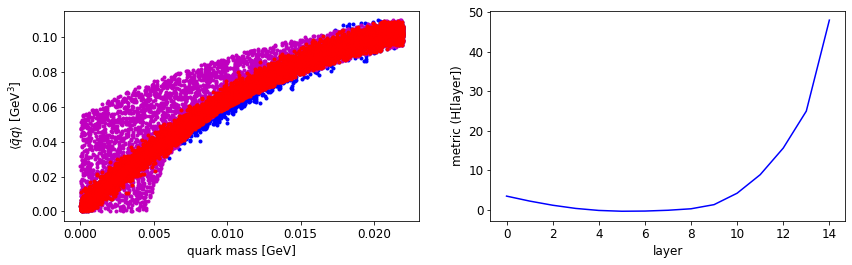

training epoch: 1200,   loss: 0.04807480424642563
lambda: 0.004956668242812157,   AdS radius: 3.9808108806610107[1/GeV]
[ 3.4850433   2.2311199   1.1788964   0.37144175 -0.13877603 -0.3416696
 -0.29533014 -0.09269604  0.28115818  1.3299019   4.2217646   8.899614
 15.631786   24.97693    47.992176  ]


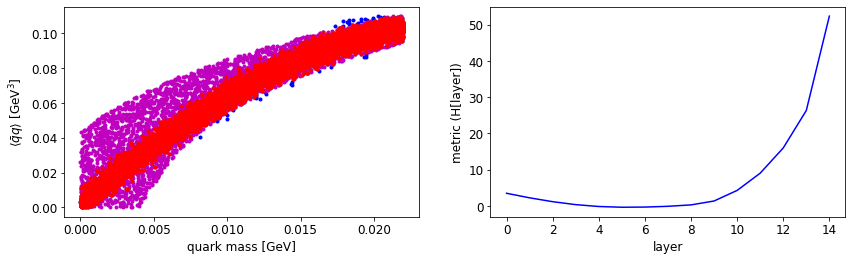

training epoch: 1300,   loss: 0.0447864904999733
lambda: 0.0045640976168215275,   AdS radius: 3.92350697517395[1/GeV]
[ 3.4964871   2.2385497   1.1742955   0.35974348 -0.15507507 -0.36006227
 -0.3120513  -0.10207745  0.28792801  1.3625425   4.2826657   9.038747
 15.999988   26.331491   52.370068  ]


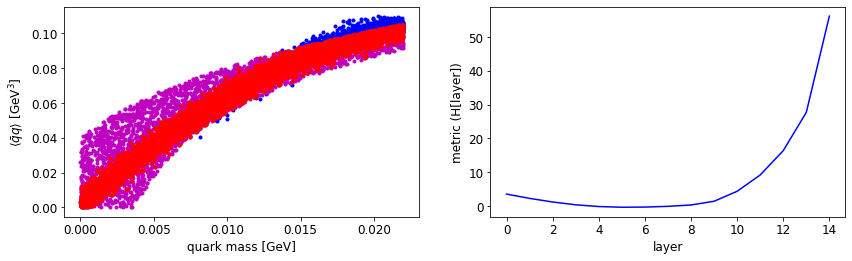

training epoch: 1400,   loss: 0.043694715946912766
lambda: 0.006158118136227131,   AdS radius: 3.863403797149658[1/GeV]
[ 3.504247    2.2459009   1.1702616   0.34775192 -0.17226806 -0.37984008
 -0.33062163 -0.113757    0.29190382  1.3916003   4.3384075   9.16959
 16.357618   27.679918   56.17074   ]


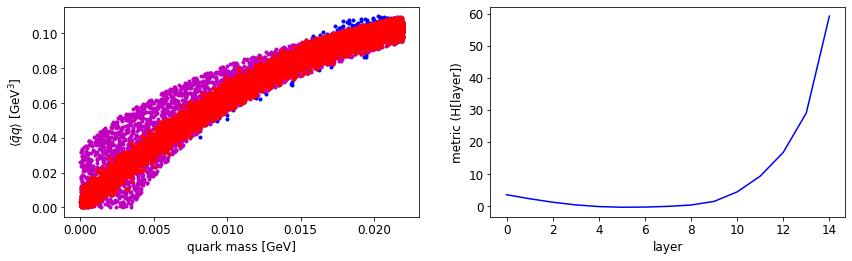

training epoch: 1500,   loss: 0.0418299101293087
lambda: 0.005100619047880173,   AdS radius: 3.821159601211548[1/GeV]
[ 3.5128777   2.2565868   1.1701164   0.33860508 -0.18745616 -0.39826962
 -0.34837037 -0.12500516  0.29604343  1.4203968   4.3924403   9.296121
 16.710634   29.016281   59.228664  ]


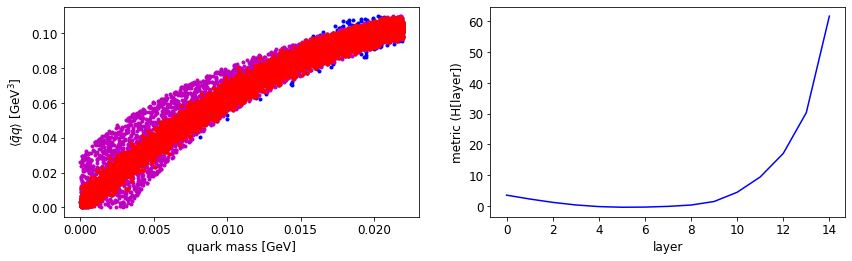

training epoch: 1600,   loss: 0.04135923087596893
lambda: 0.005106391850858927,   AdS radius: 3.7425155639648438[1/GeV]
[ 3.5195127   2.2673645   1.1715539   0.3307567  -0.20169601 -0.416021
 -0.3657029  -0.13612625  0.29993254  1.4483315   4.444699    9.419097
 17.060791   30.323906   61.687565  ]


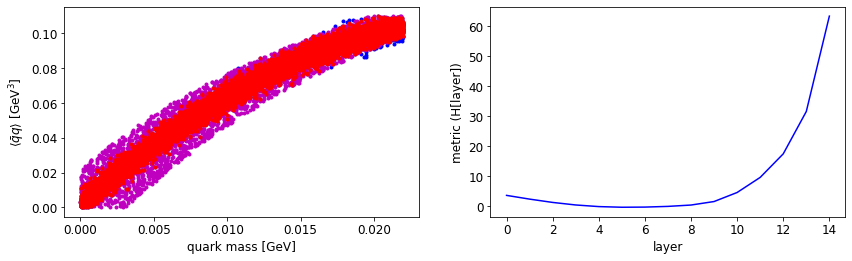

training epoch: 1700,   loss: 0.0387725792825222
lambda: 0.0032085245475172997,   AdS radius: 3.7098331451416016[1/GeV]
[ 3.5281963   2.28092     1.1767764   0.3262187  -0.21327244 -0.43165597
 -0.38144332 -0.14620431  0.30417073  1.4754996   4.4942346   9.535005
 17.397045   31.545387   63.379295  ]


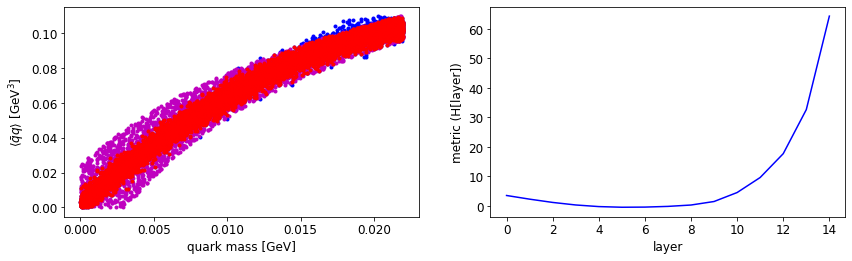

training epoch: 1800,   loss: 0.0376228392124176
lambda: 0.005328655708581209,   AdS radius: 3.67758846282959[1/GeV]
[ 3.5332398   2.2917573   1.1802653   0.31952295 -0.22768821 -0.45070654
 -0.4011133  -0.16070014  0.30343238  1.4967587   4.53591     9.638727
 17.713408   32.650536   64.34709   ]


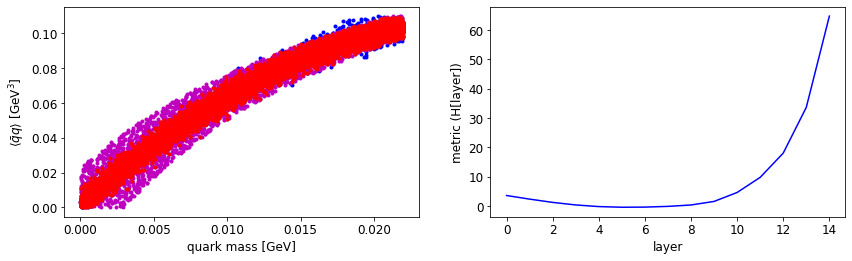

training epoch: 1900,   loss: 0.03753732144832611
lambda: 0.004941390827298164,   AdS radius: 3.64231276512146[1/GeV]
[ 3.5403702   2.3056648   1.1877546   0.3164163  -0.23927364 -0.4675348
 -0.41901705 -0.17373234  0.30398118  1.5189751   4.577428    9.740352
 18.02533    33.66132    64.804146  ]


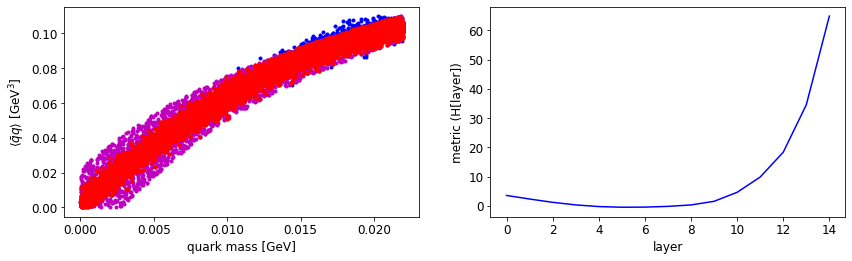

training epoch: 2000,   loss: 0.036960478872060776
lambda: 0.005590839311480522,   AdS radius: 3.6078546047210693[1/GeV]
[ 3.546804    2.3195958   1.1963277   0.31435028 -0.25035256 -0.48434818
 -0.4373364  -0.18759285  0.30320472  1.5390192   4.6152754   9.834924
 18.321236   34.53115    64.83493   ]


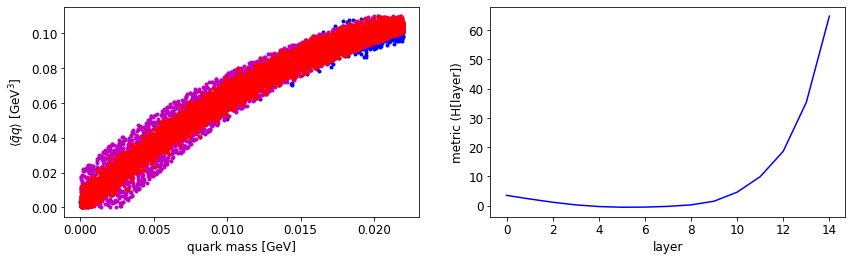

training epoch: 2100,   loss: 0.03773300349712372
lambda: 0.004677162505686283,   AdS radius: 3.579780101776123[1/GeV]
[ 3.5527744   2.3334641   1.2059877   0.31361163 -0.26042664 -0.5004824
 -0.45524865 -0.20130152  0.3022729   1.5584025   4.6518416   9.9269495
 18.60974    35.28995    64.73988   ]


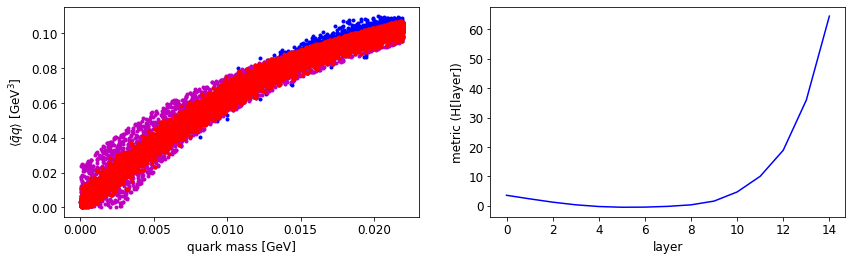

training epoch: 2200,   loss: 0.036419808864593506
lambda: 0.007794991135597229,   AdS radius: 3.565800428390503[1/GeV]
[ 3.556641    2.3454013   1.2147049   0.31220233 -0.2714913  -0.51795423
 -0.47477707 -0.21686053  0.2992207   1.5752317   4.6853986  10.014781
 18.888205   35.93976    64.54389   ]


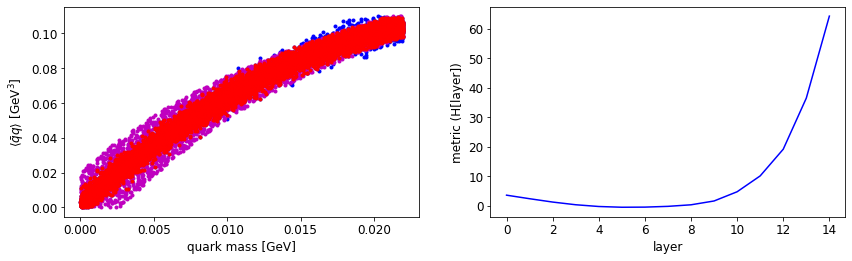

training epoch: 2300,   loss: 0.03629942983388901
lambda: 0.005843725521117449,   AdS radius: 3.536620855331421[1/GeV]
[ 3.5626895   2.3594031   1.226483    0.3144687  -0.27887693 -0.5318882
 -0.49094057 -0.22930343  0.2988385   1.5940105   4.7202506  10.102164
 19.156076   36.48429    64.30377   ]


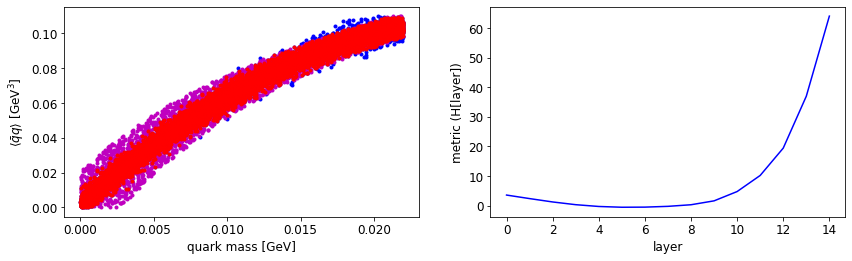

training epoch: 2400,   loss: 0.03606164827942848
lambda: 0.00655888207256794,   AdS radius: 3.5082480907440186[1/GeV]
[ 3.5670283   2.371937    1.2375108   0.31601706 -0.28757766 -0.5477145
 -0.50933915 -0.24403454  0.29644057  1.6111785   4.753836   10.189586
 19.422607   36.95067    64.00334   ]


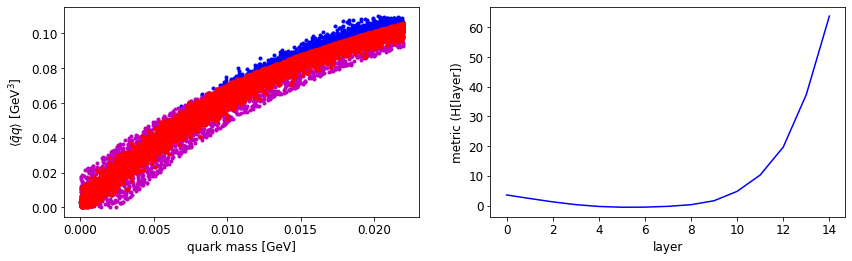

training epoch: 2500,   loss: 0.03681187331676483
lambda: 0.00790137704461813,   AdS radius: 3.4738662242889404[1/GeV]
[ 3.5721922   2.3849647   1.2497975   0.31955415 -0.29414496 -0.5614855
 -0.52581745 -0.2570766   0.29528463  1.6288904   4.7875366  10.275476
 19.674862   37.32857    63.70805   ]


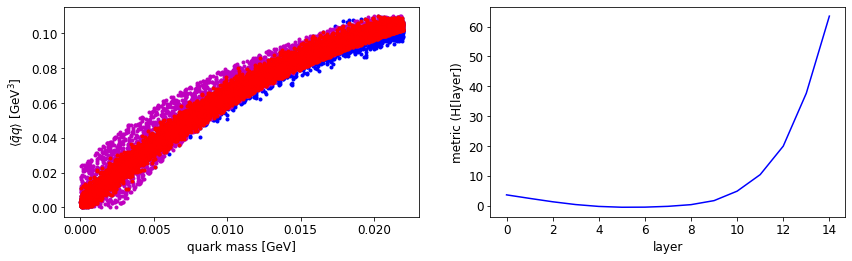

training epoch: 2600,   loss: 0.03582575172185898
lambda: 0.007586702238768339,   AdS radius: 3.462705373764038[1/GeV]
[ 3.5736523   2.3939579   1.2585856   0.3201993  -0.30351987 -0.5781829
 -0.54533744 -0.27328113  0.2907738   1.642964    4.8177986  10.358175
 19.9164     37.652958   63.52082   ]


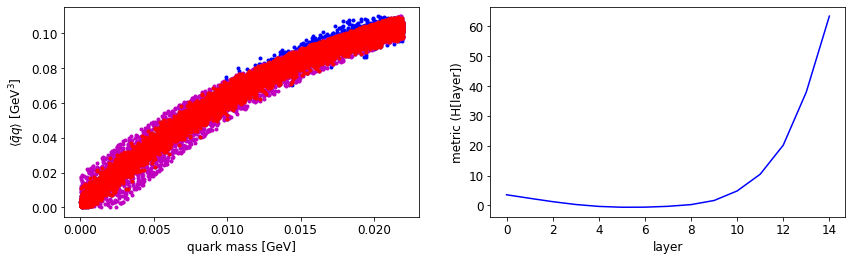

training epoch: 2700,   loss: 0.03559761866927147
lambda: 0.006428364664316177,   AdS radius: 3.4775869846343994[1/GeV]
[ 3.5795414   2.4074583   1.2723234   0.32581344 -0.3085466  -0.5912089
 -0.5615674  -0.28616408  0.29010016  1.6617385   4.8538465  10.449324
 20.165537   37.939438   63.323498  ]


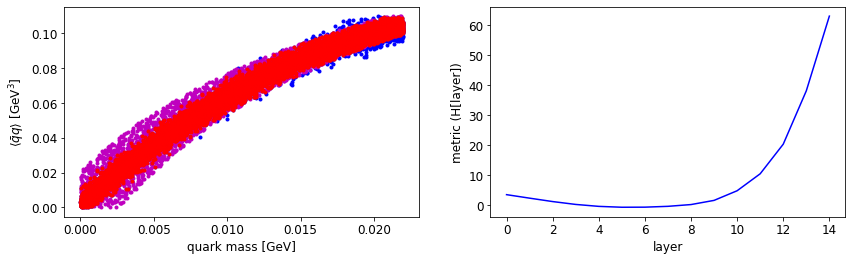

training epoch: 2800,   loss: 0.0350816510617733
lambda: 0.007423921022564173,   AdS radius: 3.456925868988037[1/GeV]
[ 3.5818827   2.4169059   1.282398    0.32872415 -0.31565353 -0.60608524
 -0.5796945  -0.30134335  0.28615218  1.6756703   4.883568   10.529301
 20.379442   38.127514   62.98928   ]


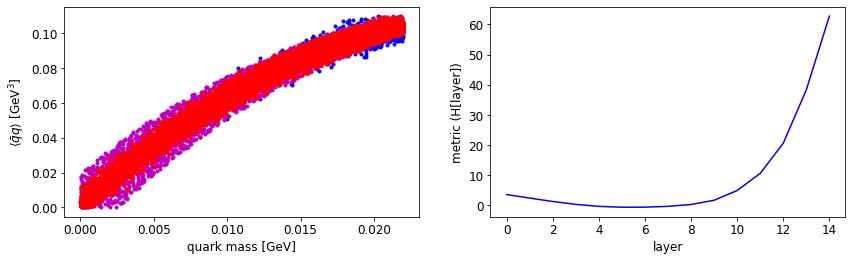

training epoch: 2900,   loss: 0.03576964512467384
lambda: 0.006337936036288738,   AdS radius: 3.4462294578552246[1/GeV]
[ 3.5861363   2.4281633   1.2946486   0.3342169  -0.32022822 -0.61868924
 -0.59571743 -0.31442955  0.28444883  1.6921266   4.91652    10.613937
 20.59228    38.29675    62.760487  ]


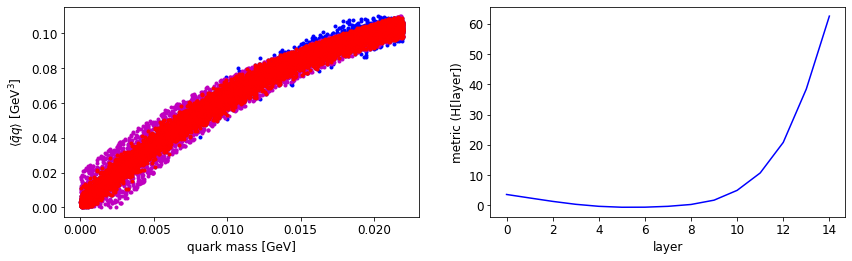

training epoch: 3000,   loss: 0.03527018800377846
lambda: 0.0074097574688494205,   AdS radius: 3.456024169921875[1/GeV]
[ 3.5888662   2.4376779   1.3054174   0.33856338 -0.3260118  -0.63279104
 -0.61347413 -0.32934335  0.2809398   1.706868    4.9482493  10.697688
 20.795397   38.432972   62.53335   ]


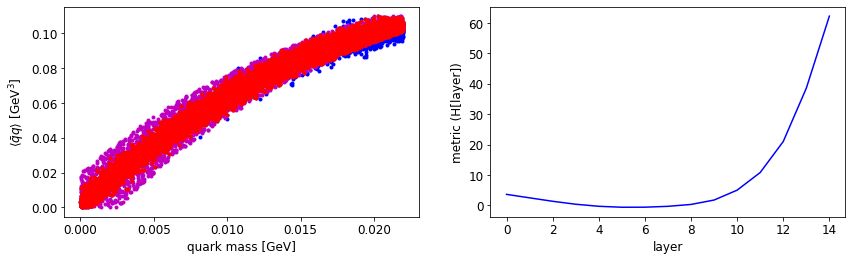

training epoch: 3100,   loss: 0.03465098515152931
lambda: 0.0063166446052491665,   AdS radius: 3.436091661453247[1/GeV]
[ 3.592037    2.4473464   1.316588    0.34396473 -0.3303288  -0.645345
 -0.629752   -0.34298855  0.27823374  1.7216699   4.979511   10.778431
 20.979027   38.522217   62.252968  ]


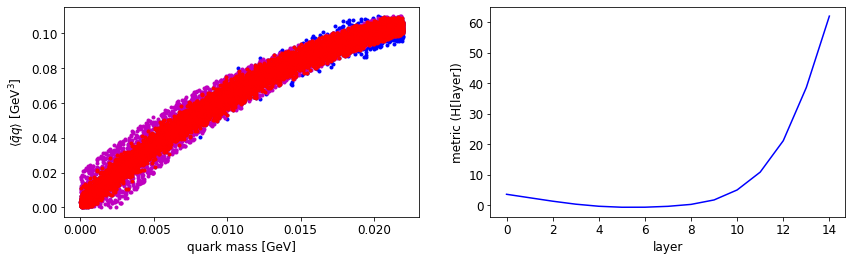

training epoch: 3200,   loss: 0.035752519965171814
lambda: 0.0075249397195875645,   AdS radius: 3.4087917804718018[1/GeV]
[ 3.5945213   2.456062    1.327042    0.3491708  -0.33453447 -0.657767
 -0.64596874 -0.35665864  0.27533925  1.7360808   5.010642   10.858469
 21.152529   38.597466   62.029957  ]


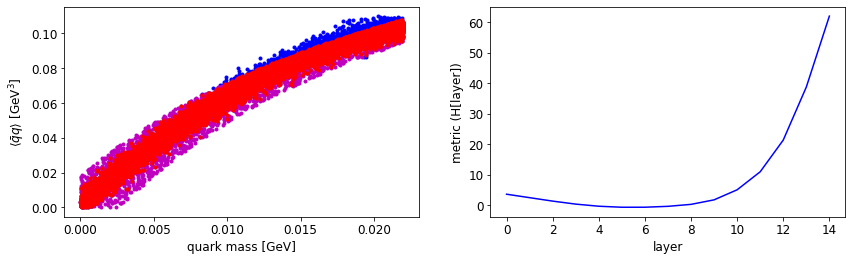

training epoch: 3300,   loss: 0.034976087510585785
lambda: 0.00836025271564722,   AdS radius: 3.399460792541504[1/GeV]
[ 3.597757    2.4652333   1.3380895   0.35535964 -0.33759797 -0.6691397
 -0.66123897 -0.36940223  0.27343506  1.751652    5.04379    10.941358
 21.323612   38.679977   61.918377  ]


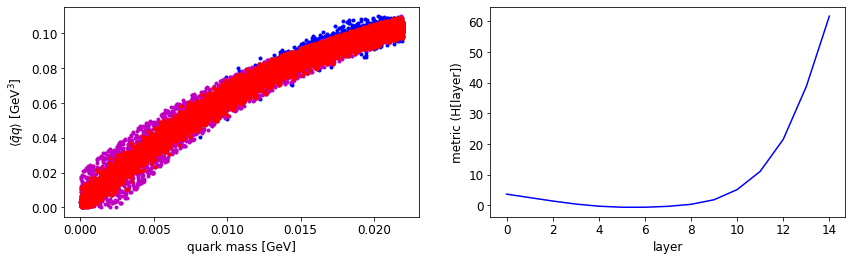

training epoch: 3400,   loss: 0.03622785955667496
lambda: 0.008985629305243492,   AdS radius: 3.3849833011627197[1/GeV]
[ 3.599323    2.4725378   1.3473761   0.3600969  -0.3420286  -0.68206096
 -0.6782623  -0.38402307  0.26958227  1.7652094   5.075029   11.021354
 21.480576   38.730972   61.716064  ]


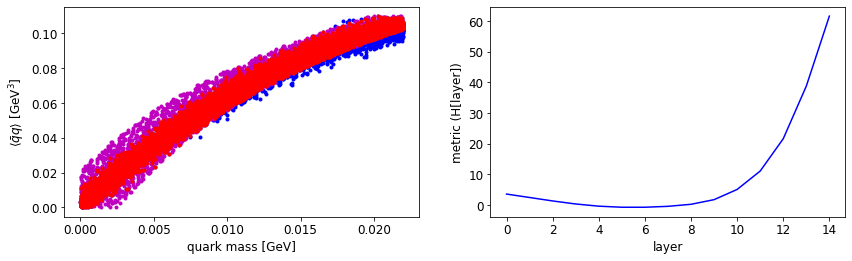

training epoch: 3500,   loss: 0.03422480449080467
lambda: 0.008102217689156532,   AdS radius: 3.3916983604431152[1/GeV]
[ 3.6006687   2.4792807   1.3561217   0.3647041  -0.34624043 -0.69467944
 -0.6950164  -0.3984628   0.26573637  1.7785825   5.106498   11.10101
 21.630344   38.78723    61.60663   ]


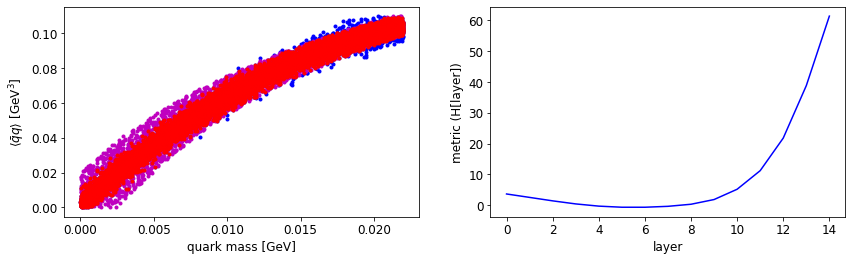

training epoch: 3600,   loss: 0.035435717552900314
lambda: 0.008814049884676933,   AdS radius: 3.3814356327056885[1/GeV]
[ 3.6035259   2.487407    1.3663201   0.37108928 -0.34844434 -0.7053277
 -0.7099318  -0.41119537  0.26342246  1.7932638   5.1392217  11.180319
 21.768793   38.818672   61.41621   ]


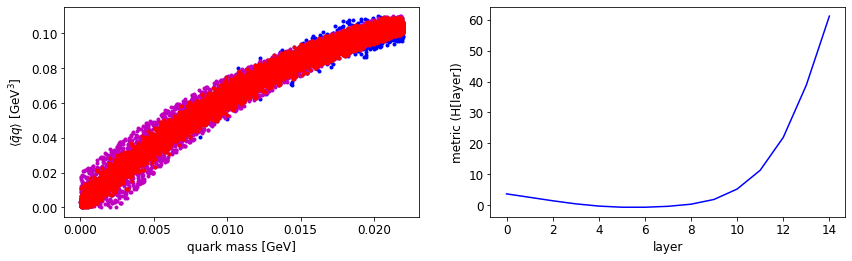

training epoch: 3700,   loss: 0.03495990112423897
lambda: 0.008420269936323166,   AdS radius: 3.3481638431549072[1/GeV]
[ 3.6061893   2.4951065   1.3761353   0.3775259  -0.35010347 -0.7151868
 -0.7240326  -0.42327154  0.26133743  1.8075227   5.171057   11.255932
 21.89272    38.830994   61.206947  ]


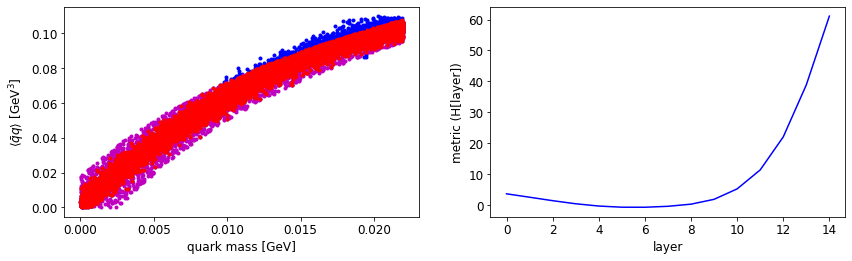

training epoch: 3800,   loss: 0.035166941583156586
lambda: 0.009737254120409489,   AdS radius: 3.361734390258789[1/GeV]
[ 3.6083941   2.5021617   1.3852954   0.3834275  -0.35234344 -0.72587943
 -0.7391853  -0.4363709   0.2585571   1.8217459   5.2042146  11.334563
 22.0188     38.86522    61.12146   ]


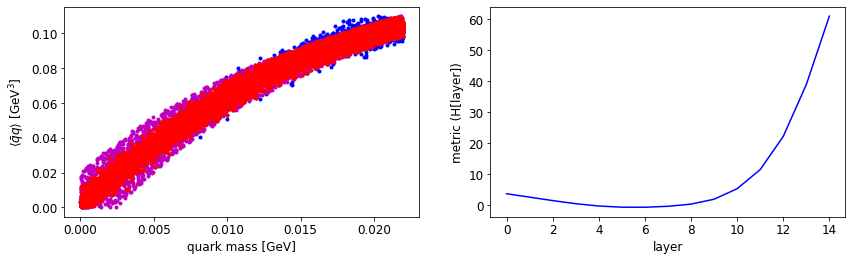

training epoch: 3900,   loss: 0.03544168919324875
lambda: 0.009595181792974472,   AdS radius: 3.3434956073760986[1/GeV]
[ 3.6095831   2.5080864   1.3934046   0.38863516 -0.35490832 -0.7367567
 -0.7545373  -0.44975668  0.2553164   1.8352797   5.2367625  11.411049
 22.13519    38.892273   61.031166  ]


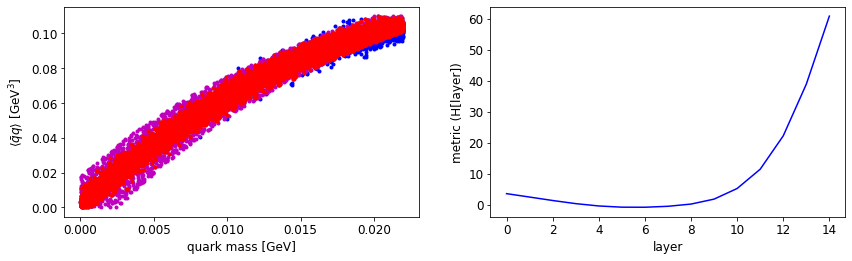

training epoch: 4000,   loss: 0.03493506461381912
lambda: 0.007370625622570515,   AdS radius: 3.3410284519195557[1/GeV]
[ 3.6123734   2.5154064   1.402864    0.3953116  -0.3559206  -0.74621487
 -0.76866996 -0.46207032  0.25305676  1.8497293   5.270259   11.486876
 22.241995   38.896034   60.837017  ]


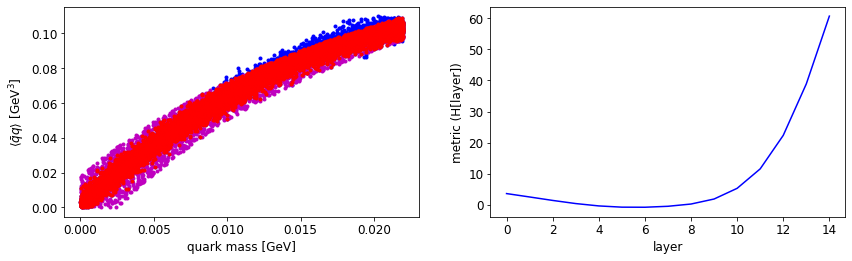

training epoch: 4100,   loss: 0.03581104427576065
lambda: 0.009289955720305443,   AdS radius: 3.3299057483673096[1/GeV]
[ 3.6142845   2.521734    1.4113657   0.4013285  -0.3571963  -0.75571537
 -0.7828158  -0.47447133  0.25049803  1.8636051   5.303295   11.560724
 22.342163   38.903572   60.71328   ]


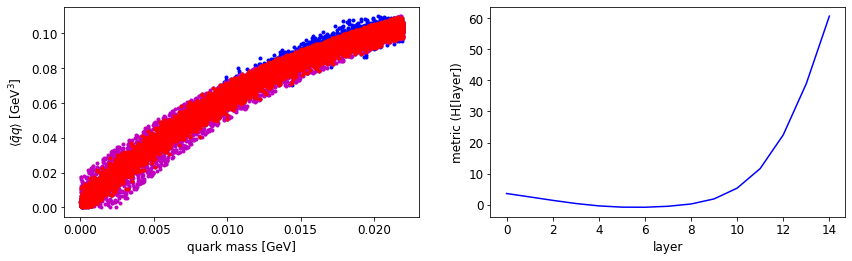

training epoch: 4200,   loss: 0.03399331495165825
lambda: 0.008549991063773632,   AdS radius: 3.3425610065460205[1/GeV]
[ 3.6160562   2.5276668   1.4193772   0.40700343 -0.35860994 -0.7653166
 -0.79714787 -0.48715156  0.24756789  1.8770626   5.3361783  11.63338
 22.436762   38.91284    60.603115  ]


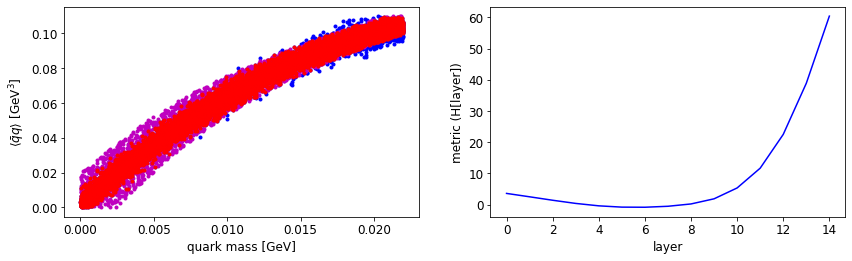

training epoch: 4300,   loss: 0.034921254962682724
lambda: 0.008722278289496899,   AdS radius: 3.3492157459259033[1/GeV]
[ 3.616954    2.5326483   1.426425    0.41184956 -0.36070794 -0.77563983
 -0.81234336 -0.50084424  0.24348152  1.8892071   5.367583   11.702408
 22.519335   38.8957     60.406647  ]


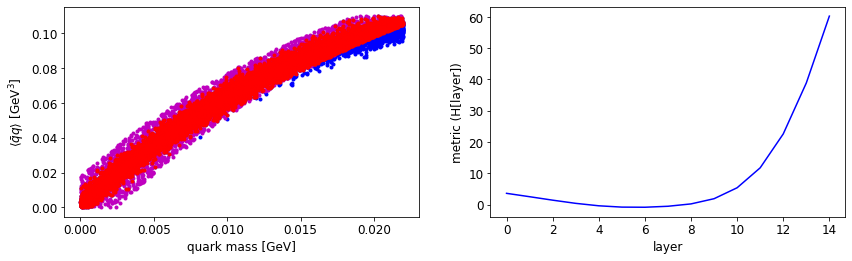

training epoch: 4400,   loss: 0.03373316675424576
lambda: 0.0059216865338385105,   AdS radius: 3.350550413131714[1/GeV]
[ 3.619339    2.539091    1.4349512   0.418361   -0.36088544 -0.7839468
 -0.8255631  -0.51263815  0.24118665  1.9030594   5.4008207  11.771867
 22.59783    38.878803   60.23923   ]


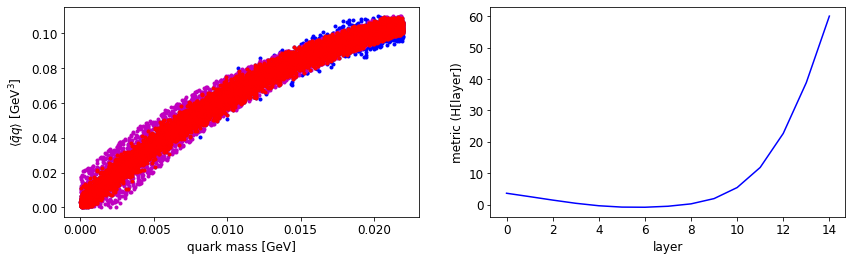

training epoch: 4500,   loss: 0.03462372347712517
lambda: 0.009412777610123158,   AdS radius: 3.3148536682128906[1/GeV]
[ 3.6202857   2.543918    1.4418424   0.42352086 -0.36191383 -0.79268944
 -0.8390738  -0.5248838   0.23792465  1.9151094   5.431294   11.83496
 22.66313    38.843456   60.02234   ]


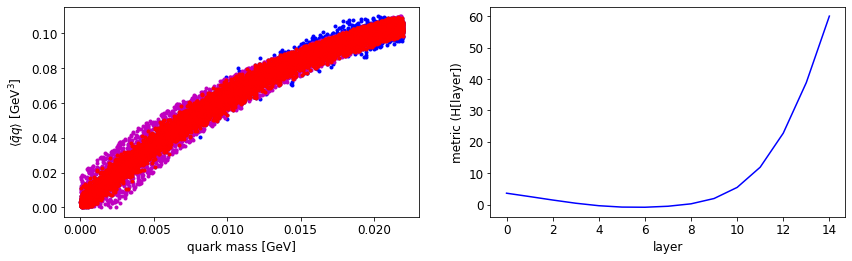

training epoch: 4600,   loss: 0.034216608852148056
lambda: 0.009359085001051426,   AdS radius: 3.3335914611816406[1/GeV]
[ 3.6216056   2.5490117   1.4490234   0.42900687 -0.36266527 -0.8013659
 -0.85269994 -0.53715336  0.23511092  1.9285905   5.465003   11.903719
 22.73884    38.855785   60.033955  ]


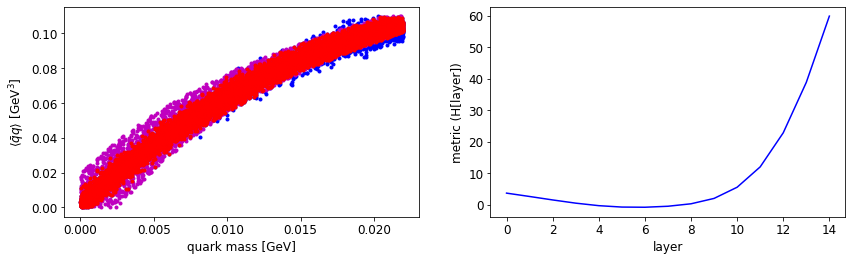

training epoch: 4700,   loss: 0.03412840887904167
lambda: 0.009919153526425362,   AdS radius: 3.3076603412628174[1/GeV]
[ 3.622377    2.5532887   1.455316    0.43385947 -0.3635292  -0.8096792
 -0.86579055 -0.5490846   0.23199125  1.9406945   5.4958997  11.965265
 22.799406   38.83816    59.895397  ]


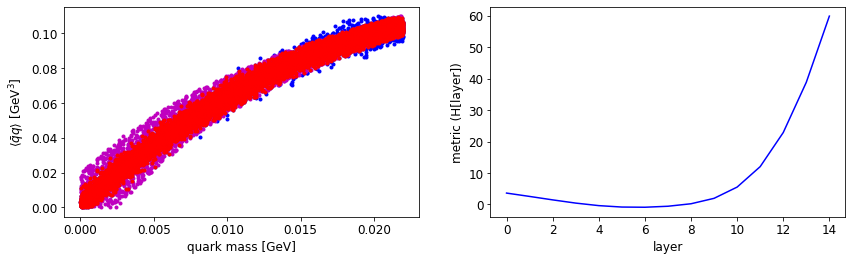

training epoch: 4800,   loss: 0.03404955565929413
lambda: 0.010800212621688843,   AdS radius: 3.3051676750183105[1/GeV]
[ 3.623602    2.5578866   1.4619625   0.43913132 -0.36393014 -0.8176235
 -0.87862897 -0.56074417  0.22940026  1.9539001   5.528952   12.029789
 22.864815   38.84501    59.870117  ]


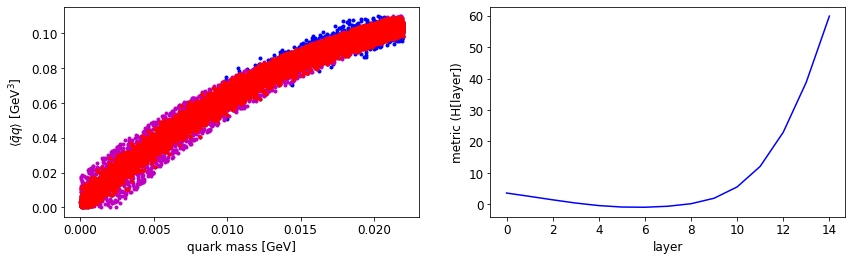

training epoch: 4900,   loss: 0.034825000911951065
lambda: 0.00899374857544899,   AdS radius: 3.302927255630493[1/GeV]
[ 3.62607     2.5636024   1.4696413   0.4455554  -0.36299375 -0.82413673
 -0.8900772  -0.57108235  0.22804354  1.9682906   5.563226   12.094241
 22.92769    38.851643   59.8231    ]


In [20]:
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [21]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))

[ 3.6269584   2.5675619   1.4754343   0.450147   -0.36370403 -0.83216745
 -0.90307206 -0.5831354   0.22467043  1.9802268   5.5944176  12.152831
 22.978964   38.831867   59.67474   ]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)